# Import Necessary Library

In [1]:
# importing libraries
import pandas as pd
import scipy
import numpy as np

import pickle
from os import path

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import seaborn as sns
import matplotlib.pyplot as plt

# Import Dataset

In [2]:
df_raw = pd.read_csv("D:\SMTR 7\Koding\SKC\mitm-dataset\MitM.csv", low_memory = False)
df_raw.head()

,frame.time_delta,frame.time_delta_displayed,frame.time_epoch,frame.time_invalid,frame.time_relative,ip.src,ip.dst,tcp.srcport,tcp.dstport,eth.src,...,mqtt.topic,mqtt.topic_len,mqtt.username,mqtt.username_len,mqtt.ver,mqtt.willmsg,mqtt.willmsg_len,mqtt.willtopic,mqtt.willtopic_len,type
0,0.000000,0.000000,1.529668e+09,NaN,0.000000,192.168.1.1,192.168.1.102,22.0,53940.0,18:a6:f7:eb:77:26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal
1,0.000481,0.000481,1.529668e+09,NaN,0.000481,192.168.1.1,192.168.1.102,22.0,53940.0,18:a6:f7:eb:77:26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal
2,0.000423,0.000423,1.529668e+09,NaN,0.000904,192.168.1.1,192.168.1.102,22.0,53940.0,18:a6:f7:eb:77:26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal
3,0.000274,0.000274,1.529668e+09,NaN,0.001178,192.168.1.102,192.168.1.1,53940.0,22.0,30:5a:3a:62:72:80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal
4,0.000861,0.000861,1.529668e+09,NaN,0.002039,192.168.1.102,192.168.1.1,53940.0,22.0,30:5a:3a:62:72:80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal


In [3]:
df_raw.isnull().sum()

frame.time_delta                   0
frame.time_delta_displayed         0
frame.time_epoch                   0
frame.time_invalid            110668
frame.time_relative                0
                               ...  
mqtt.willmsg                  110668
mqtt.willmsg_len              110668
mqtt.willtopic                110668
mqtt.willtopic_len            110668
type                               0
Length: 67, dtype: int64

In [4]:
# Drop columns with too many missing values (e.g., 50% or more)
threshold = 0.5
df = df_raw.copy()
df = df.loc[:, df.isnull().mean() < threshold]

# Impute remaining null values using median for numerical columns
num_cols = df.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='median')
df[num_cols] = imputer.fit_transform(df[num_cols])

# Forward fill for categorical columns (if applicable)
cat_cols = df.select_dtypes(include=[object]).columns
df[cat_cols] = df[cat_cols].ffill()

In [5]:
df['type'] = df['type'].map({'normal': 0, 'mitm': 1})


In [6]:
# Select only numeric columns for correlation analysis
numeric_df = df.copy()
num_col = numeric_df.select_dtypes(include=[np.number]).columns
data_num = df[num_col].copy()
data_num.head()

,frame.time_delta,frame.time_delta_displayed,frame.time_epoch,frame.time_relative,tcp.srcport,tcp.dstport,frame.cap_len,frame.encap_type,frame.ignored,frame.len,frame.marked,frame.number,frame.offset_shift,type
0,0.000000,0.000000,1.529668e+09,0.000000,22.0,53940.0,134.0,1.0,0.0,134.0,0.0,1.0,0.0,0
1,0.000481,0.000481,1.529668e+09,0.000481,22.0,53940.0,150.0,1.0,0.0,150.0,0.0,2.0,0.0,0
2,0.000423,0.000423,1.529668e+09,0.000904,22.0,53940.0,118.0,1.0,0.0,118.0,0.0,3.0,0.0,0
3,0.000274,0.000274,1.529668e+09,0.001178,53940.0,22.0,66.0,1.0,0.0,66.0,0.0,4.0,0.0,0
4,0.000861,0.000861,1.529668e+09,0.002039,53940.0,22.0,66.0,1.0,0.0,66.0,0.0,5.0,0.0,0


In [7]:
cat_col = df.columns.difference(num_col)
cat_col = cat_col[1:]
cat_col

Index(['eth.src', 'ip.dst', 'ip.src'], dtype='object')

In [8]:
# creating a dataframe with only categorical attributes
data_cat = df_raw[cat_col].copy()
data_cat.head()

,eth.src,ip.dst,ip.src
0,18:a6:f7:eb:77:26,192.168.1.102,192.168.1.1
1,18:a6:f7:eb:77:26,192.168.1.102,192.168.1.1
2,18:a6:f7:eb:77:26,192.168.1.102,192.168.1.1
3,30:5a:3a:62:72:80,192.168.1.1,192.168.1.102
4,30:5a:3a:62:72:80,192.168.1.1,192.168.1.102


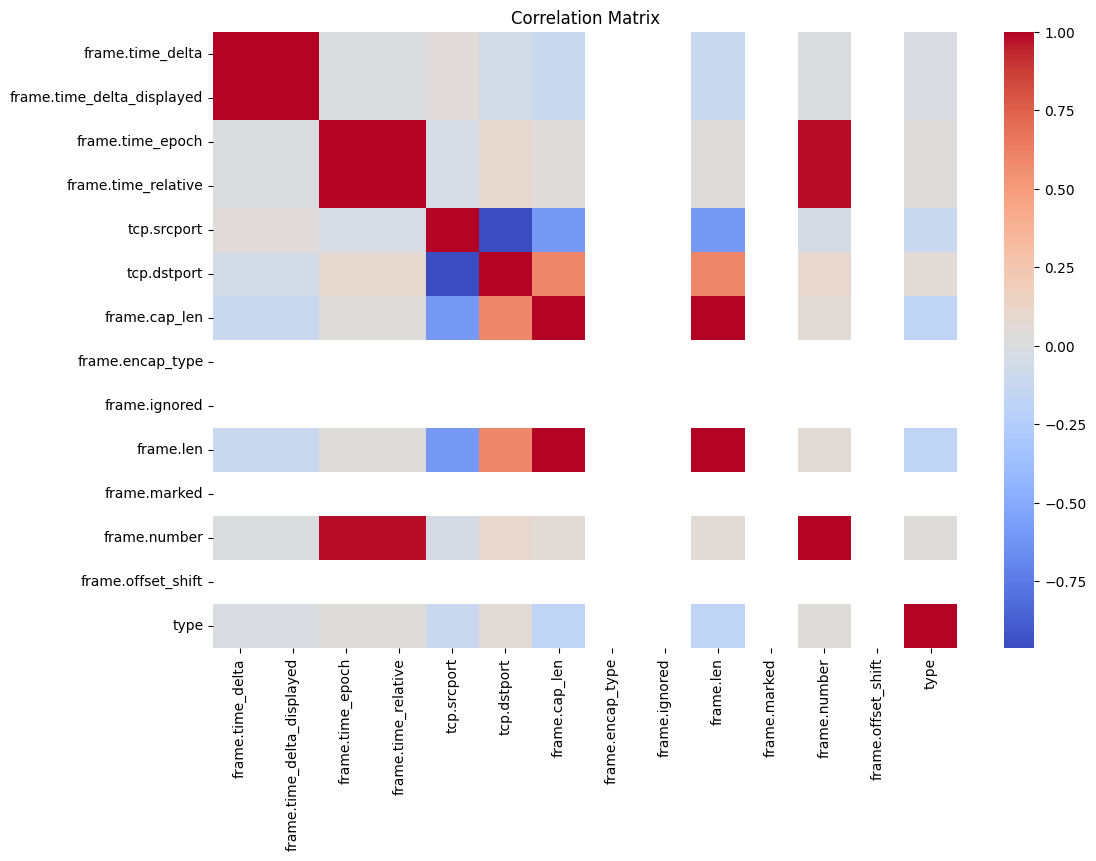

In [9]:
# Correlation analysis for numeric features
corr_matrix = data_num.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [10]:
data_cat = pd.get_dummies(data_cat,columns=cat_col)
data_cat.head()

,eth.src_18:a6:f7:eb:77:26,eth.src_30:5a:3a:62:72:80,eth.src_48:5a:3f:93:39:9c,eth.src_4c:74:03:07:92:4f,eth.src_60:01:94:37:e0:e1,eth.src_68:c6:3a:8b:d0:1e,eth.src_74:d4:35:ed:f7:06,eth.src_74:d4:35:ef:e5:5a,eth.src_a0:20:a6:17:44:ed,eth.src_b8:27:eb:73:32:30,...,ip.src_89.255.249.53,ip.src_91.189.89.198,ip.src_91.215.103.66,ip.src_93.184.220.70,ip.src_93.93.51.190,ip.src_93.93.51.200,ip.src_93.93.53.190,ip.src_93.93.53.191,ip.src_94.23.82.225,ip.src_95.211.229.246
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [11]:
df = pd.concat([df, data_cat],axis=1)

In [12]:
df.drop(columns=cat_col,inplace=True)

# Data Normalization

In [13]:
num_col = list(df.select_dtypes(include='number').columns)
num_col.remove('type')
num_col

['frame.time_delta',
 'frame.time_delta_displayed',
 'frame.time_epoch',
 'frame.time_relative',
 'tcp.srcport',
 'tcp.dstport',
 'frame.cap_len',
 'frame.encap_type',
 'frame.ignored',
 'frame.len',
 'frame.marked',
 'frame.number',
 'frame.offset_shift']

In [14]:
minmax_scale = MinMaxScaler(feature_range=(0, 1))

In [15]:
def normalization(df,col):
  for i in col:
    arr = df[i]
    arr = np.array(arr)
    df[i] = minmax_scale.fit_transform(arr.reshape(len(arr),1))
  return df
df.head()

,frame.time_delta,frame.time_delta_displayed,frame.time_epoch,frame.time_relative,tcp.srcport,tcp.dstport,eth.dst,frame.cap_len,frame.encap_type,frame.ignored,...,ip.src_89.255.249.53,ip.src_91.189.89.198,ip.src_91.215.103.66,ip.src_93.184.220.70,ip.src_93.93.51.190,ip.src_93.93.51.200,ip.src_93.93.53.190,ip.src_93.93.53.191,ip.src_94.23.82.225,ip.src_95.211.229.246
0,0.000000,0.000000,1.529668e+09,0.000000,22.0,53940.0,30:5a:3a:62:72:80,134.0,1.0,0.0,...,False,False,False,False,False,False,False,False,False,False
1,0.000481,0.000481,1.529668e+09,0.000481,22.0,53940.0,30:5a:3a:62:72:80,150.0,1.0,0.0,...,False,False,False,False,False,False,False,False,False,False
2,0.000423,0.000423,1.529668e+09,0.000904,22.0,53940.0,30:5a:3a:62:72:80,118.0,1.0,0.0,...,False,False,False,False,False,False,False,False,False,False
3,0.000274,0.000274,1.529668e+09,0.001178,53940.0,22.0,18:a6:f7:eb:77:26,66.0,1.0,0.0,...,False,False,False,False,False,False,False,False,False,False
4,0.000861,0.000861,1.529668e+09,0.002039,53940.0,22.0,18:a6:f7:eb:77:26,66.0,1.0,0.0,...,False,False,False,False,False,False,False,False,False,False


In [16]:
df_normalization = df.copy()
df_normalization = normalization(df.copy(),num_col)
df_normalization = df_normalization.drop(columns=['eth.dst'])

In [17]:
df_normalization['type'].value_counts()

type
0    106813
1      3855
Name: count, dtype: int64

In [18]:
# changing attack labels into two categories 'normal' and 'mitm'
bin_label = pd.DataFrame(df_normalization.type.map(lambda x:'normal' if x==0 else 'mitm'))

In [19]:
bin_label['type'] = bin_label['type'].map({'normal': 0, 'mitm': 1})
bin_label.value_counts()

type
0       106813
1         3855
Name: count, dtype: int64

In [20]:
# creating a dataframe with binary labels (normal,abnormal)
bin_data = df_normalization.copy()

# Menambahkan kolom 'type' dengan bin_label
bin_data['type'] = bin_label

In [21]:
import pandas as pd

# Contoh: Salin DataFrame normalisasi
bin_data = df_normalization.copy()

# Pastikan bin_label adalah Series atau list dengan panjang yang sesuai
if isinstance(bin_label, (list, np.ndarray)):
    bin_label = pd.Series(bin_label)

# Cek apakah panjang bin_label sama dengan bin_data
if len(bin_data) == len(bin_label):
    bin_data['type'] = bin_label
else:
    print("Panjang bin_label tidak sesuai dengan jumlah baris bin_data.")

# Menampilkan beberapa baris untuk memeriksa
print(bin_data.head())
print(bin_data.columns)  # Memeriksa semua kolom dalam bin_data

   frame.time_delta  frame.time_delta_displayed  frame.time_epoch  \
0          0.000000                    0.000000      0.000000e+00   
1          0.000049                    0.000049      1.022127e-07   
2          0.000043                    0.000043      1.920853e-07   
3          0.000028                    0.000028      2.502929e-07   
4          0.000087                    0.000087      4.332396e-07   

   frame.time_relative  tcp.srcport  tcp.dstport  frame.cap_len  \
0         0.000000e+00     0.000000     0.884525       0.076305   
1         1.021975e-07     0.000000     0.884525       0.087015   
2         1.920719e-07     0.000000     0.884525       0.065596   
3         2.502883e-07     0.884525     0.000000       0.030790   
4         4.332240e-07     0.884525     0.000000       0.030790   

   frame.encap_type  frame.ignored  frame.len  ...  ip.src_89.255.249.53  \
0               0.0            0.0   0.076305  ...                 False   
1               0.0           

In [22]:
bin_data['type'].value_counts()

type
0    106813
1      3855
Name: count, dtype: int64

In [23]:
# label encoding (0,1) binary labels
le1 = preprocessing.LabelEncoder()
enc_label = bin_label.apply(le1.fit_transform)
bin_data['type'] = enc_label

In [24]:
le1.classes_

array([0, 1])

# Data Visualization

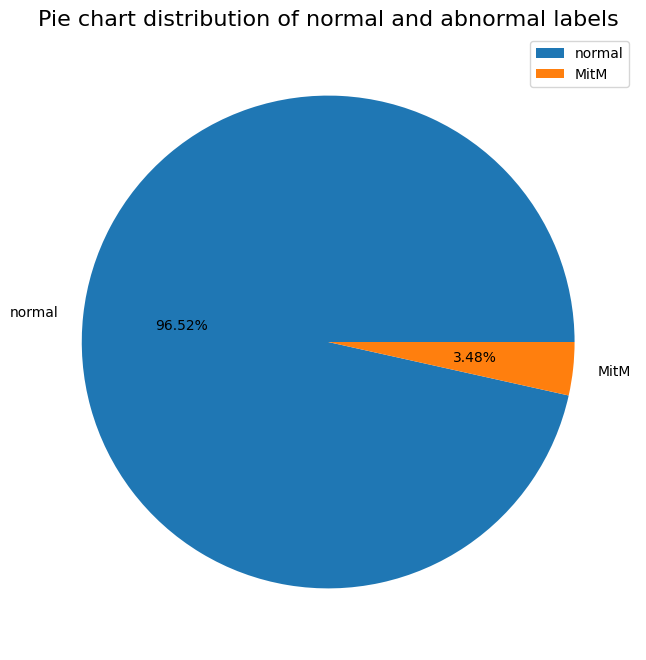

In [25]:
plt.figure(figsize=(8,8))
plt.pie(df_raw.type.value_counts(),labels=['normal','MitM'],autopct='%0.2f%%')
plt.title("Pie chart distribution of normal and abnormal labels",fontsize=16)
plt.legend()
# plt.savefig('/content/gdrive/My Drive/ASDOS/template/Topik1_Studi Transformer-Based Sequence Modelling untuk Deteksi Ransomware Melalui Analisis Trafik Jaringan yang Mengenkripsi Secara Tiba-tiba/plot/Pie_chart_binary2.png')
plt.show()

# SMOTE

In [26]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [27]:
X = bin_data.drop(columns=['type'],axis=1)
y = bin_label

In [28]:
y.head()

,type
0,0
1,0
2,0
3,0
4,0


In [29]:
X.head()

,frame.time_delta,frame.time_delta_displayed,frame.time_epoch,frame.time_relative,tcp.srcport,tcp.dstport,frame.cap_len,frame.encap_type,frame.ignored,frame.len,...,ip.src_89.255.249.53,ip.src_91.189.89.198,ip.src_91.215.103.66,ip.src_93.184.220.70,ip.src_93.93.51.190,ip.src_93.93.51.200,ip.src_93.93.53.190,ip.src_93.93.53.191,ip.src_94.23.82.225,ip.src_95.211.229.246
0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.884525,0.076305,0.0,0.0,0.076305,...,False,False,False,False,False,False,False,False,False,False
1,0.000049,0.000049,1.022127e-07,1.021975e-07,0.000000,0.884525,0.087015,0.0,0.0,0.087015,...,False,False,False,False,False,False,False,False,False,False
2,0.000043,0.000043,1.920853e-07,1.920719e-07,0.000000,0.884525,0.065596,0.0,0.0,0.065596,...,False,False,False,False,False,False,False,False,False,False
3,0.000028,0.000028,2.502929e-07,2.502883e-07,0.884525,0.000000,0.030790,0.0,0.0,0.030790,...,False,False,False,False,False,False,False,False,False,False
4,0.000087,0.000087,4.332396e-07,4.332240e-07,0.884525,0.000000,0.030790,0.0,0.0,0.030790,...,False,False,False,False,False,False,False,False,False,False


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

,frame.time_delta,frame.time_delta_displayed,frame.time_epoch,frame.time_relative,tcp.srcport,tcp.dstport,frame.cap_len,frame.encap_type,frame.ignored,frame.len,...,ip.src_89.255.249.53,ip.src_91.189.89.198,ip.src_91.215.103.66,ip.src_93.184.220.70,ip.src_93.93.51.190,ip.src_93.93.51.200,ip.src_93.93.53.190,ip.src_93.93.53.191,ip.src_94.23.82.225,ip.src_95.211.229.246
29334,0.000005,0.000005,0.267485,0.267485,0.006907,0.665797,0.046854,0.0,0.0,0.046854,...,False,False,False,False,False,False,False,False,False,False
73708,0.000006,0.000006,0.655324,0.655324,0.926342,0.006907,0.038822,0.0,0.0,0.038822,...,False,False,False,False,False,False,False,False,False,False
48869,0.000402,0.000402,0.400053,0.400053,0.863560,0.006907,0.049531,0.0,0.0,0.049531,...,False,False,False,False,False,False,False,False,False,False
44163,0.005940,0.005940,0.359819,0.359819,0.006907,0.665797,0.014726,0.0,0.0,0.014726,...,False,False,False,False,False,False,False,False,False,False
23787,0.000006,0.000006,0.242490,0.242490,0.601933,0.006907,0.038822,0.0,0.0,0.038822,...,False,False,False,False,False,False,False,False,False,False


In [31]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Melatih model dengan data yang telah di-resample
model = RandomForestClassifier(random_state=42)
model.fit(X_resampled, y_resampled)

# Menguji model
y_pred = model.predict(X_test)

# Menampilkan laporan klasifikasi
print(classification_report(y_test, y_pred))

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


              precision    recall  f1-score   support

           0       1.00      0.99      1.00     21390
           1       0.81      0.95      0.88       744

    accuracy                           0.99     22134
   macro avg       0.90      0.97      0.94     22134
weighted avg       0.99      0.99      0.99     22134



In [32]:
print("Distribusi label sebelum SMOTE:", Counter(y_train))
print("Distribusi label setelah SMOTE:", Counter(y_resampled))

Distribusi label sebelum SMOTE: Counter({'type': 1})
Distribusi label setelah SMOTE: Counter({'type': 1})


In [33]:
# Mengonversi X_resampled menjadi DataFrame
X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)

# Mengonversi y_resampled menjadi DataFrame dengan kolom 'type'
y_resampled_df = pd.DataFrame(y_resampled, columns=['type'])

# Menggabungkan DataFrame
combined_df = pd.concat([X_resampled_df, y_resampled_df], axis=1)

combined_df

,frame.time_delta,frame.time_delta_displayed,frame.time_epoch,frame.time_relative,tcp.srcport,tcp.dstport,frame.cap_len,frame.encap_type,frame.ignored,frame.len,...,ip.src_91.189.89.198,ip.src_91.215.103.66,ip.src_93.184.220.70,ip.src_93.93.51.190,ip.src_93.93.51.200,ip.src_93.93.53.190,ip.src_93.93.53.191,ip.src_94.23.82.225,ip.src_95.211.229.246,type
0,0.000005,0.000005,0.267485,0.267485,0.006907,0.665797,0.046854,0.0,0.0,0.046854,...,False,False,False,False,False,False,False,False,False,0
1,0.000006,0.000006,0.655324,0.655324,0.926342,0.006907,0.038822,0.0,0.0,0.038822,...,False,False,False,False,False,False,False,False,False,0
2,0.000402,0.000402,0.400053,0.400053,0.863560,0.006907,0.049531,0.0,0.0,0.049531,...,False,False,False,False,False,False,False,False,False,0
3,0.005940,0.005940,0.359819,0.359819,0.006907,0.665797,0.014726,0.0,0.0,0.014726,...,False,False,False,False,False,False,False,False,False,0
4,0.000006,0.000006,0.242490,0.242490,0.601933,0.006907,0.038822,0.0,0.0,0.038822,...,False,False,False,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170841,0.000003,0.000003,0.603987,0.603987,0.006907,0.665797,0.014726,0.0,0.0,0.014726,...,False,False,False,False,False,False,False,False,False,1
170842,0.000003,0.000003,0.342446,0.342446,0.006907,0.665797,0.014726,0.0,0.0,0.014726,...,False,False,False,False,False,False,False,False,False,1
170843,0.000969,0.000969,0.342267,0.342267,0.006907,0.665797,0.014726,0.0,0.0,0.014726,...,False,False,False,False,False,False,False,False,False,1
170844,0.000972,0.000972,0.147220,0.147220,0.006907,0.665797,0.014726,0.0,0.0,0.014726,...,False,False,False,False,False,False,False,False,False,1


In [34]:
mitm_df = combined_df[combined_df['type'] == 1]

In [35]:
mitm_df

,frame.time_delta,frame.time_delta_displayed,frame.time_epoch,frame.time_relative,tcp.srcport,tcp.dstport,frame.cap_len,frame.encap_type,frame.ignored,frame.len,...,ip.src_91.189.89.198,ip.src_91.215.103.66,ip.src_93.184.220.70,ip.src_93.93.51.190,ip.src_93.93.51.200,ip.src_93.93.53.190,ip.src_93.93.53.191,ip.src_94.23.82.225,ip.src_95.211.229.246,type
12,0.001772,0.001772,0.342479,0.342479,0.006907,0.665797,0.014726,0.0,0.0,0.014726,...,False,False,False,False,False,False,False,False,False,1
17,0.001064,0.001064,0.743333,0.743333,0.006907,0.665797,0.014726,0.0,0.0,0.014726,...,False,False,False,False,False,False,False,False,False,1
35,0.001044,0.001044,0.743373,0.743373,0.006907,0.665797,0.014726,0.0,0.0,0.014726,...,False,False,False,False,False,False,False,False,False,1
54,0.000003,0.000003,0.603794,0.603794,0.006907,0.665797,0.014726,0.0,0.0,0.014726,...,False,False,False,False,False,False,False,False,False,1
56,0.000690,0.000690,0.370235,0.370235,0.030530,0.806421,0.022758,0.0,0.0,0.022758,...,False,False,False,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170841,0.000003,0.000003,0.603987,0.603987,0.006907,0.665797,0.014726,0.0,0.0,0.014726,...,False,False,False,False,False,False,False,False,False,1
170842,0.000003,0.000003,0.342446,0.342446,0.006907,0.665797,0.014726,0.0,0.0,0.014726,...,False,False,False,False,False,False,False,False,False,1
170843,0.000969,0.000969,0.342267,0.342267,0.006907,0.665797,0.014726,0.0,0.0,0.014726,...,False,False,False,False,False,False,False,False,False,1
170844,0.000972,0.000972,0.147220,0.147220,0.006907,0.665797,0.014726,0.0,0.0,0.014726,...,False,False,False,False,False,False,False,False,False,1


In [36]:
combined_df = pd.concat([bin_data, mitm_df], axis=0, ignore_index=True)
combined_df['type'].value_counts()


type
0    106813
1     89278
Name: count, dtype: int64

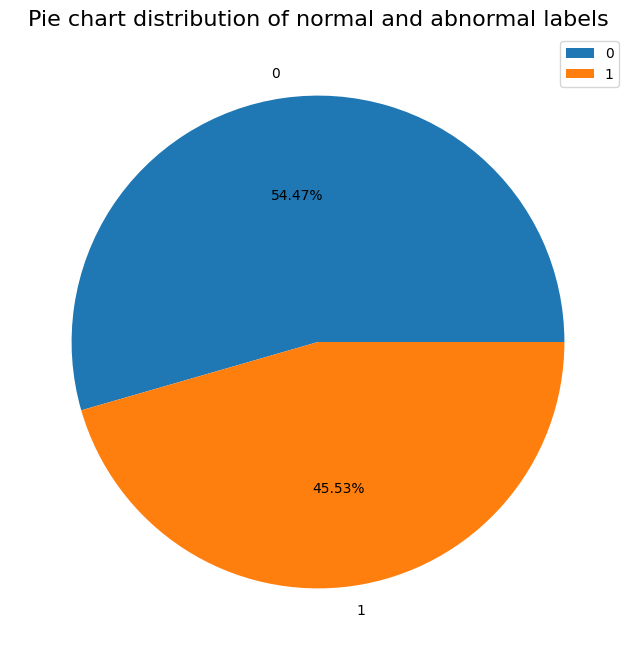

In [37]:
plt.figure(figsize=(8,8))
plt.pie(combined_df.type.value_counts(),labels=['0','1'],autopct='%0.2f%%')
plt.title("Pie chart distribution of normal and abnormal labels",fontsize=16)
plt.legend()
# plt.savefig('/content/gdrive/My Drive/ASDOS/template/Topik1_Studi Transformer-Based Sequence Modelling untuk Deteksi Ransomware Melalui Analisis Trafik Jaringan yang Mengenkripsi Secara Tiba-tiba/plot/Pie_chart_binary2.png')
plt.show()

# Import Transformer

In [38]:
%pip install transformers tensorflow

# Transformer Decoder

Fold 1
Epoch 1/50 - Train Loss: 0.0961, Train Acc: 0.9535, Val Loss: 0.0902, Val Acc: 0.9559
Epoch 2/50 - Train Loss: 0.0803, Train Acc: 0.9627, Val Loss: 0.0769, Val Acc: 0.9636
Epoch 3/50 - Train Loss: 0.0746, Train Acc: 0.9658, Val Loss: 0.0858, Val Acc: 0.9587
Epoch 4/50 - Train Loss: 0.0722, Train Acc: 0.9670, Val Loss: 0.0732, Val Acc: 0.9674
Epoch 5/50 - Train Loss: 0.0702, Train Acc: 0.9684, Val Loss: 0.0714, Val Acc: 0.9690
Epoch 6/50 - Train Loss: 0.0632, Train Acc: 0.9719, Val Loss: 0.0656, Val Acc: 0.9722
Epoch 7/50 - Train Loss: 0.0614, Train Acc: 0.9731, Val Loss: 0.0639, Val Acc: 0.9731
Epoch 8/50 - Train Loss: 0.0609, Train Acc: 0.9735, Val Loss: 0.0624, Val Acc: 0.9746
Epoch 9/50 - Train Loss: 0.0599, Train Acc: 0.9739, Val Loss: 0.0633, Val Acc: 0.9726
Epoch 10/50 - Train Loss: 0.0590, Train Acc: 0.9748, Val Loss: 0.0620, Val Acc: 0.9737
Epoch 11/50 - Train Loss: 0.0585, Train Acc: 0.9750, Val Loss: 0.0607, Val Acc: 0.9756
Epoch 12/50 - Train Loss: 0.0578, Train Acc: 

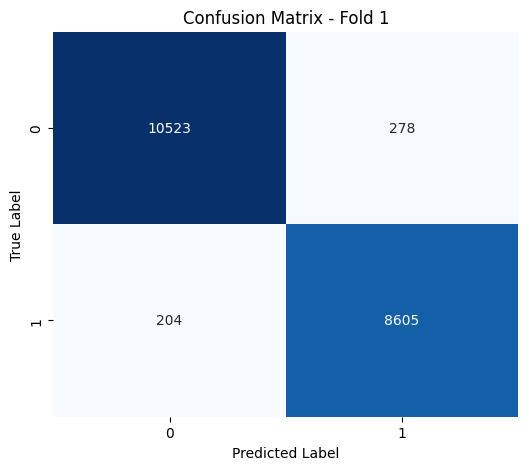

Fold 1 - Accuracy: 97.54%
Fold 1 - F1 Score: 0.9754
Fold 1 - Precision: 0.9755
Fold 1 - Recall: 0.9754
Fold 2
Epoch 1/50 - Train Loss: 0.0970, Train Acc: 0.9534, Val Loss: 0.0855, Val Acc: 0.9547
Epoch 2/50 - Train Loss: 0.0826, Train Acc: 0.9609, Val Loss: 0.0853, Val Acc: 0.9600
Epoch 3/50 - Train Loss: 0.0765, Train Acc: 0.9657, Val Loss: 0.0714, Val Acc: 0.9668
Epoch 4/50 - Train Loss: 0.0729, Train Acc: 0.9670, Val Loss: 0.0700, Val Acc: 0.9667
Epoch 5/50 - Train Loss: 0.0712, Train Acc: 0.9678, Val Loss: 0.0699, Val Acc: 0.9659
Epoch 6/50 - Train Loss: 0.0651, Train Acc: 0.9702, Val Loss: 0.0649, Val Acc: 0.9684
Epoch 7/50 - Train Loss: 0.0636, Train Acc: 0.9705, Val Loss: 0.0644, Val Acc: 0.9683
Epoch 8/50 - Train Loss: 0.0629, Train Acc: 0.9709, Val Loss: 0.0639, Val Acc: 0.9692
Epoch 9/50 - Train Loss: 0.0623, Train Acc: 0.9713, Val Loss: 0.0628, Val Acc: 0.9682
Epoch 10/50 - Train Loss: 0.0619, Train Acc: 0.9718, Val Loss: 0.0625, Val Acc: 0.9717
Epoch 11/50 - Train Loss: 0.0

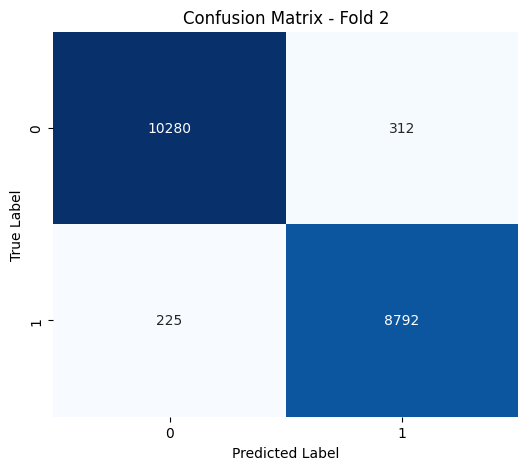

Fold 2 - Accuracy: 97.26%
Fold 2 - F1 Score: 0.9726
Fold 2 - Precision: 0.9727
Fold 2 - Recall: 0.9726
Fold 3
Epoch 1/50 - Train Loss: 0.0951, Train Acc: 0.9541, Val Loss: 0.0949, Val Acc: 0.9605
Epoch 2/50 - Train Loss: 0.0795, Train Acc: 0.9635, Val Loss: 0.0759, Val Acc: 0.9658
Epoch 3/50 - Train Loss: 0.0752, Train Acc: 0.9659, Val Loss: 0.0700, Val Acc: 0.9688
Epoch 4/50 - Train Loss: 0.0732, Train Acc: 0.9671, Val Loss: 0.0674, Val Acc: 0.9709
Epoch 5/50 - Train Loss: 0.0713, Train Acc: 0.9681, Val Loss: 0.0683, Val Acc: 0.9687
Epoch 6/50 - Train Loss: 0.0649, Train Acc: 0.9711, Val Loss: 0.0619, Val Acc: 0.9725
Epoch 7/50 - Train Loss: 0.0631, Train Acc: 0.9725, Val Loss: 0.0603, Val Acc: 0.9749
Epoch 8/50 - Train Loss: 0.0626, Train Acc: 0.9726, Val Loss: 0.0596, Val Acc: 0.9752
Epoch 9/50 - Train Loss: 0.0619, Train Acc: 0.9732, Val Loss: 0.0590, Val Acc: 0.9759
Epoch 10/50 - Train Loss: 0.0616, Train Acc: 0.9733, Val Loss: 0.0589, Val Acc: 0.9750
Epoch 11/50 - Train Loss: 0.0

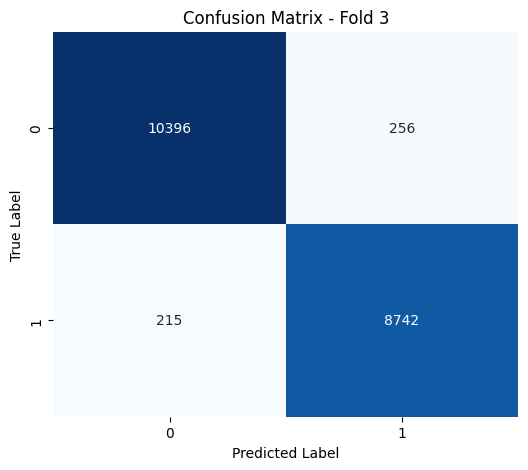

Fold 3 - Accuracy: 97.60%
Fold 3 - F1 Score: 0.9760
Fold 3 - Precision: 0.9760
Fold 3 - Recall: 0.9760
Fold 4
Epoch 1/50 - Train Loss: 0.0961, Train Acc: 0.9529, Val Loss: 0.0856, Val Acc: 0.9582
Epoch 2/50 - Train Loss: 0.0843, Train Acc: 0.9593, Val Loss: 0.0738, Val Acc: 0.9673
Epoch 3/50 - Train Loss: 0.0769, Train Acc: 0.9649, Val Loss: 0.0719, Val Acc: 0.9683
Epoch 4/50 - Train Loss: 0.0739, Train Acc: 0.9664, Val Loss: 0.0661, Val Acc: 0.9693
Epoch 5/50 - Train Loss: 0.0712, Train Acc: 0.9677, Val Loss: 0.0656, Val Acc: 0.9699
Epoch 6/50 - Train Loss: 0.0646, Train Acc: 0.9707, Val Loss: 0.0597, Val Acc: 0.9715
Epoch 7/50 - Train Loss: 0.0628, Train Acc: 0.9718, Val Loss: 0.0578, Val Acc: 0.9732
Epoch 8/50 - Train Loss: 0.0618, Train Acc: 0.9724, Val Loss: 0.0578, Val Acc: 0.9744
Epoch 9/50 - Train Loss: 0.0615, Train Acc: 0.9732, Val Loss: 0.0563, Val Acc: 0.9760
Epoch 10/50 - Train Loss: 0.0609, Train Acc: 0.9732, Val Loss: 0.0561, Val Acc: 0.9753
Epoch 11/50 - Train Loss: 0.0

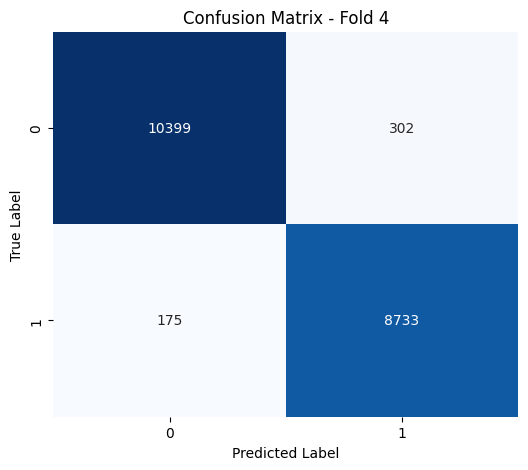

Fold 4 - Accuracy: 97.57%
Fold 4 - F1 Score: 0.9757
Fold 4 - Precision: 0.9758
Fold 4 - Recall: 0.9757
Fold 5
Epoch 1/50 - Train Loss: 0.0949, Train Acc: 0.9534, Val Loss: 0.0788, Val Acc: 0.9598
Epoch 2/50 - Train Loss: 0.0805, Train Acc: 0.9621, Val Loss: 0.0734, Val Acc: 0.9657
Epoch 3/50 - Train Loss: 0.0757, Train Acc: 0.9651, Val Loss: 0.0682, Val Acc: 0.9698
Epoch 4/50 - Train Loss: 0.0733, Train Acc: 0.9664, Val Loss: 0.0655, Val Acc: 0.9696
Epoch 5/50 - Train Loss: 0.0714, Train Acc: 0.9678, Val Loss: 0.0702, Val Acc: 0.9707
Epoch 6/50 - Train Loss: 0.0647, Train Acc: 0.9709, Val Loss: 0.0592, Val Acc: 0.9732
Epoch 7/50 - Train Loss: 0.0625, Train Acc: 0.9721, Val Loss: 0.0580, Val Acc: 0.9745
Epoch 8/50 - Train Loss: 0.0616, Train Acc: 0.9730, Val Loss: 0.0569, Val Acc: 0.9761
Epoch 9/50 - Train Loss: 0.0607, Train Acc: 0.9734, Val Loss: 0.0574, Val Acc: 0.9759
Epoch 10/50 - Train Loss: 0.0602, Train Acc: 0.9739, Val Loss: 0.0560, Val Acc: 0.9768
Epoch 11/50 - Train Loss: 0.0

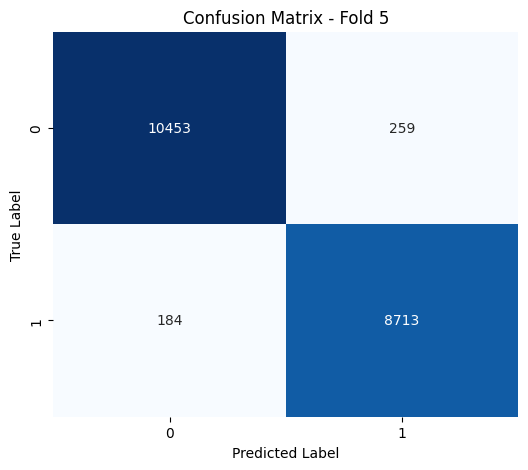

Fold 5 - Accuracy: 97.74%
Fold 5 - F1 Score: 0.9774
Fold 5 - Precision: 0.9775
Fold 5 - Recall: 0.9774
Fold 6
Epoch 1/50 - Train Loss: 0.0961, Train Acc: 0.9528, Val Loss: 0.0920, Val Acc: 0.9550
Epoch 2/50 - Train Loss: 0.0843, Train Acc: 0.9590, Val Loss: 0.0853, Val Acc: 0.9629
Epoch 3/50 - Train Loss: 0.0777, Train Acc: 0.9640, Val Loss: 0.0811, Val Acc: 0.9615
Epoch 4/50 - Train Loss: 0.0750, Train Acc: 0.9658, Val Loss: 0.0713, Val Acc: 0.9674
Epoch 5/50 - Train Loss: 0.0732, Train Acc: 0.9667, Val Loss: 0.0708, Val Acc: 0.9687
Epoch 6/50 - Train Loss: 0.0671, Train Acc: 0.9701, Val Loss: 0.0646, Val Acc: 0.9733
Epoch 7/50 - Train Loss: 0.0654, Train Acc: 0.9708, Val Loss: 0.0629, Val Acc: 0.9729
Epoch 8/50 - Train Loss: 0.0649, Train Acc: 0.9712, Val Loss: 0.0626, Val Acc: 0.9720
Epoch 9/50 - Train Loss: 0.0640, Train Acc: 0.9714, Val Loss: 0.0624, Val Acc: 0.9731
Epoch 10/50 - Train Loss: 0.0631, Train Acc: 0.9720, Val Loss: 0.0619, Val Acc: 0.9732
Epoch 11/50 - Train Loss: 0.0

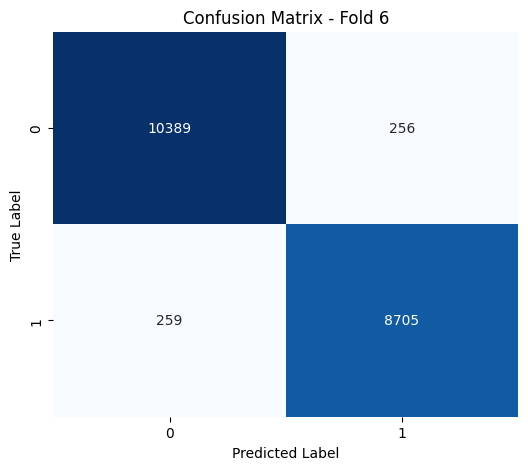

Fold 6 - Accuracy: 97.37%
Fold 6 - F1 Score: 0.9737
Fold 6 - Precision: 0.9737
Fold 6 - Recall: 0.9737
Fold 7
Epoch 1/50 - Train Loss: 0.0950, Train Acc: 0.9537, Val Loss: 0.1176, Val Acc: 0.9496
Epoch 2/50 - Train Loss: 0.0810, Train Acc: 0.9619, Val Loss: 0.0763, Val Acc: 0.9639
Epoch 3/50 - Train Loss: 0.0758, Train Acc: 0.9652, Val Loss: 0.0724, Val Acc: 0.9672
Epoch 4/50 - Train Loss: 0.0736, Train Acc: 0.9663, Val Loss: 0.0696, Val Acc: 0.9695
Epoch 5/50 - Train Loss: 0.0717, Train Acc: 0.9678, Val Loss: 0.0683, Val Acc: 0.9691
Epoch 6/50 - Train Loss: 0.0653, Train Acc: 0.9704, Val Loss: 0.0623, Val Acc: 0.9707
Epoch 7/50 - Train Loss: 0.0635, Train Acc: 0.9711, Val Loss: 0.0608, Val Acc: 0.9706
Epoch 8/50 - Train Loss: 0.0627, Train Acc: 0.9717, Val Loss: 0.0598, Val Acc: 0.9736
Epoch 9/50 - Train Loss: 0.0621, Train Acc: 0.9721, Val Loss: 0.0598, Val Acc: 0.9725
Epoch 10/50 - Train Loss: 0.0614, Train Acc: 0.9727, Val Loss: 0.0582, Val Acc: 0.9756
Epoch 11/50 - Train Loss: 0.0

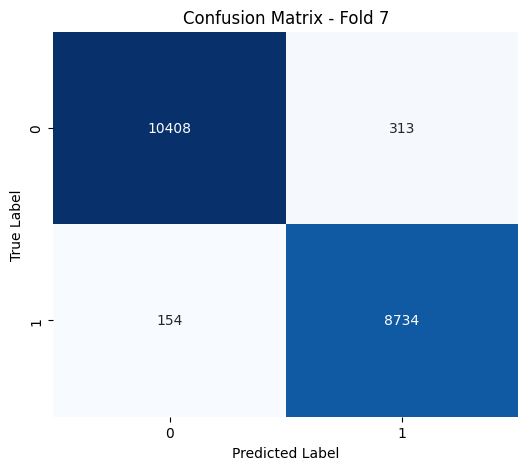

Fold 7 - Accuracy: 97.62%
Fold 7 - F1 Score: 0.9762
Fold 7 - Precision: 0.9763
Fold 7 - Recall: 0.9762
Fold 8
Epoch 1/50 - Train Loss: 0.0973, Train Acc: 0.9524, Val Loss: 0.0840, Val Acc: 0.9609
Epoch 2/50 - Train Loss: 0.0824, Train Acc: 0.9607, Val Loss: 0.0753, Val Acc: 0.9660
Epoch 3/50 - Train Loss: 0.0764, Train Acc: 0.9653, Val Loss: 0.0716, Val Acc: 0.9672
Epoch 4/50 - Train Loss: 0.0734, Train Acc: 0.9665, Val Loss: 0.0678, Val Acc: 0.9686
Epoch 5/50 - Train Loss: 0.0716, Train Acc: 0.9675, Val Loss: 0.0726, Val Acc: 0.9682
Epoch 6/50 - Train Loss: 0.0671, Train Acc: 0.9694, Val Loss: 0.0641, Val Acc: 0.9702
Epoch 7/50 - Train Loss: 0.0648, Train Acc: 0.9703, Val Loss: 0.0613, Val Acc: 0.9709
Epoch 8/50 - Train Loss: 0.0640, Train Acc: 0.9709, Val Loss: 0.0611, Val Acc: 0.9712
Epoch 9/50 - Train Loss: 0.0635, Train Acc: 0.9711, Val Loss: 0.0589, Val Acc: 0.9723
Epoch 10/50 - Train Loss: 0.0629, Train Acc: 0.9717, Val Loss: 0.0584, Val Acc: 0.9753
Epoch 11/50 - Train Loss: 0.0

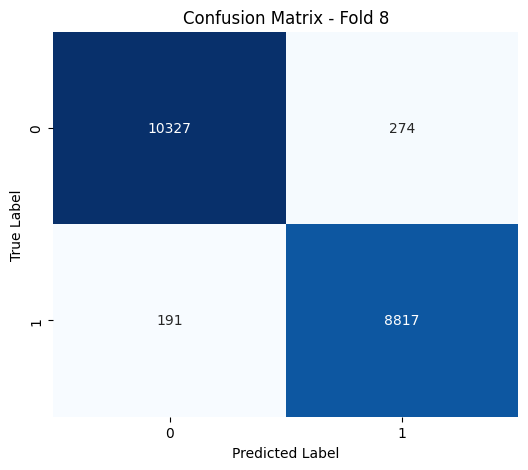

Fold 8 - Accuracy: 97.63%
Fold 8 - F1 Score: 0.9763
Fold 8 - Precision: 0.9763
Fold 8 - Recall: 0.9763
Fold 9
Epoch 1/50 - Train Loss: 0.0959, Train Acc: 0.9532, Val Loss: 0.0854, Val Acc: 0.9558
Epoch 2/50 - Train Loss: 0.0841, Train Acc: 0.9598, Val Loss: 0.1105, Val Acc: 0.9566
Epoch 3/50 - Train Loss: 0.0799, Train Acc: 0.9634, Val Loss: 0.0758, Val Acc: 0.9627
Epoch 4/50 - Train Loss: 0.0745, Train Acc: 0.9659, Val Loss: 0.0737, Val Acc: 0.9670
Epoch 5/50 - Train Loss: 0.0723, Train Acc: 0.9672, Val Loss: 0.0689, Val Acc: 0.9694
Epoch 6/50 - Train Loss: 0.0661, Train Acc: 0.9702, Val Loss: 0.0648, Val Acc: 0.9712
Epoch 7/50 - Train Loss: 0.0645, Train Acc: 0.9704, Val Loss: 0.0638, Val Acc: 0.9706
Epoch 8/50 - Train Loss: 0.0635, Train Acc: 0.9708, Val Loss: 0.0616, Val Acc: 0.9720
Epoch 9/50 - Train Loss: 0.0629, Train Acc: 0.9720, Val Loss: 0.0605, Val Acc: 0.9726
Epoch 10/50 - Train Loss: 0.0621, Train Acc: 0.9725, Val Loss: 0.0605, Val Acc: 0.9736
Epoch 11/50 - Train Loss: 0.0

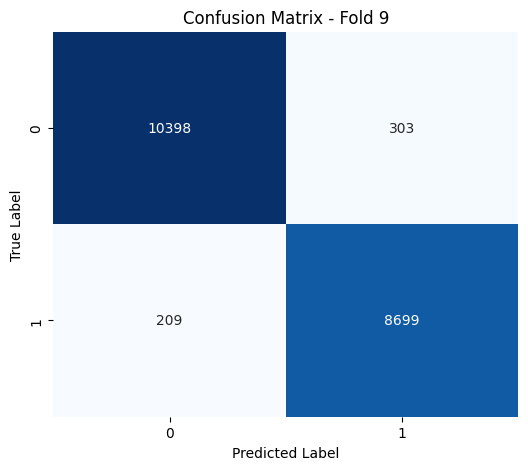

Fold 9 - Accuracy: 97.39%
Fold 9 - F1 Score: 0.9739
Fold 9 - Precision: 0.9740
Fold 9 - Recall: 0.9739
Fold 10
Epoch 1/50 - Train Loss: 0.0965, Train Acc: 0.9528, Val Loss: 0.0897, Val Acc: 0.9535
Epoch 2/50 - Train Loss: 0.0832, Train Acc: 0.9605, Val Loss: 0.0783, Val Acc: 0.9655
Epoch 3/50 - Train Loss: 0.0769, Train Acc: 0.9652, Val Loss: 0.0718, Val Acc: 0.9692
Epoch 4/50 - Train Loss: 0.0736, Train Acc: 0.9669, Val Loss: 0.0720, Val Acc: 0.9658
Epoch 5/50 - Train Loss: 0.0716, Train Acc: 0.9681, Val Loss: 0.0732, Val Acc: 0.9637
Epoch 6/50 - Train Loss: 0.0634, Train Acc: 0.9728, Val Loss: 0.0631, Val Acc: 0.9735
Epoch 7/50 - Train Loss: 0.0620, Train Acc: 0.9734, Val Loss: 0.0614, Val Acc: 0.9742
Epoch 8/50 - Train Loss: 0.0610, Train Acc: 0.9741, Val Loss: 0.0609, Val Acc: 0.9742
Epoch 9/50 - Train Loss: 0.0599, Train Acc: 0.9748, Val Loss: 0.0606, Val Acc: 0.9734
Epoch 10/50 - Train Loss: 0.0596, Train Acc: 0.9747, Val Loss: 0.0603, Val Acc: 0.9732
Epoch 11/50 - Train Loss: 0.

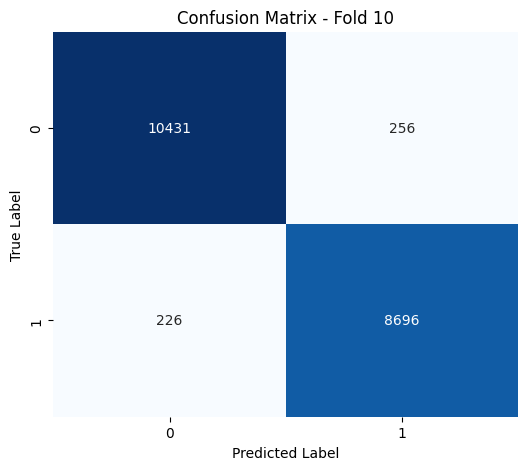

Fold 10 - Accuracy: 97.54%
Fold 10 - F1 Score: 0.9754
Fold 10 - Precision: 0.9754
Fold 10 - Recall: 0.9754
Average Accuracy: 97.53%
Average F1 Score: 0.9753
Average Precision: 0.9753
Average Recall: 0.9753


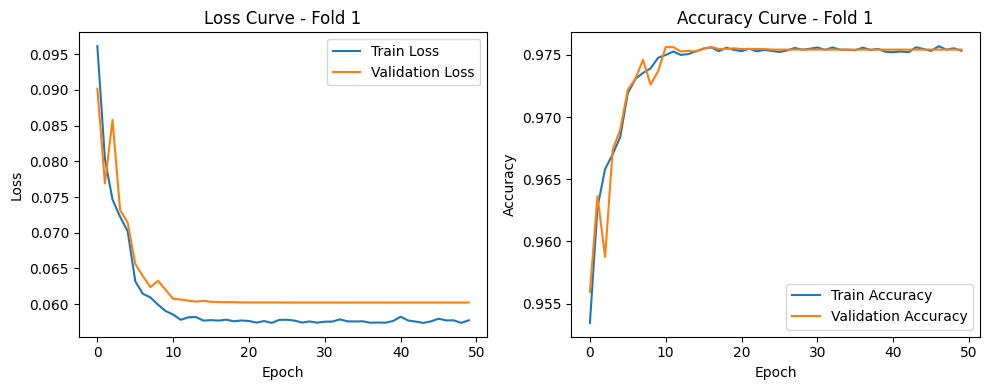

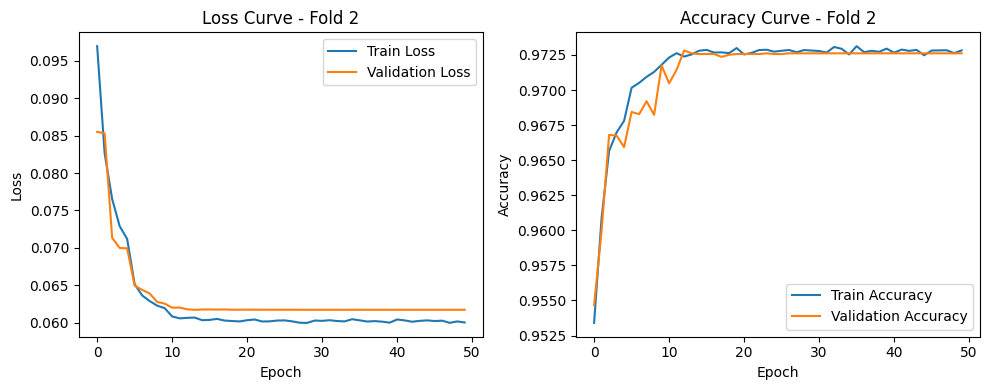

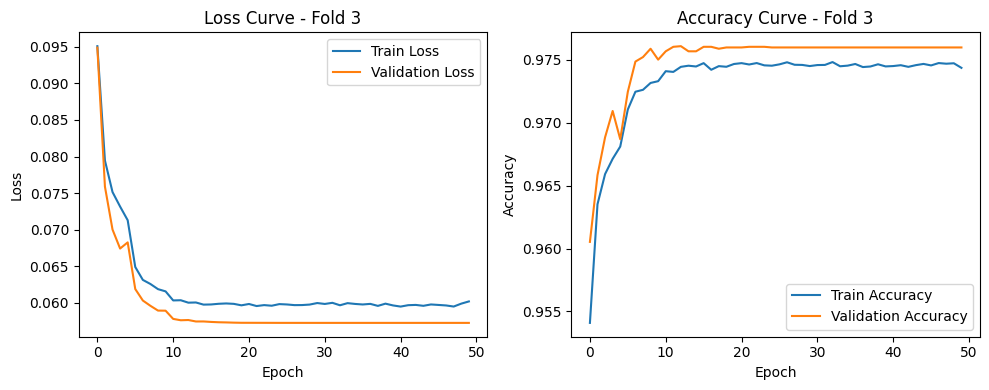

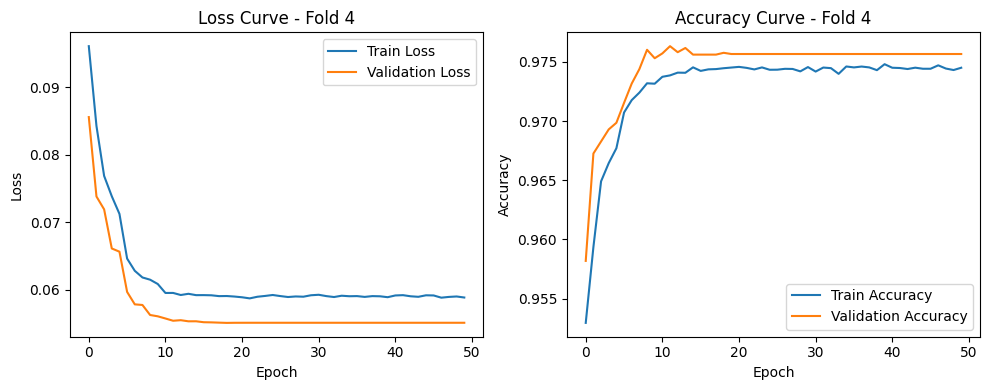

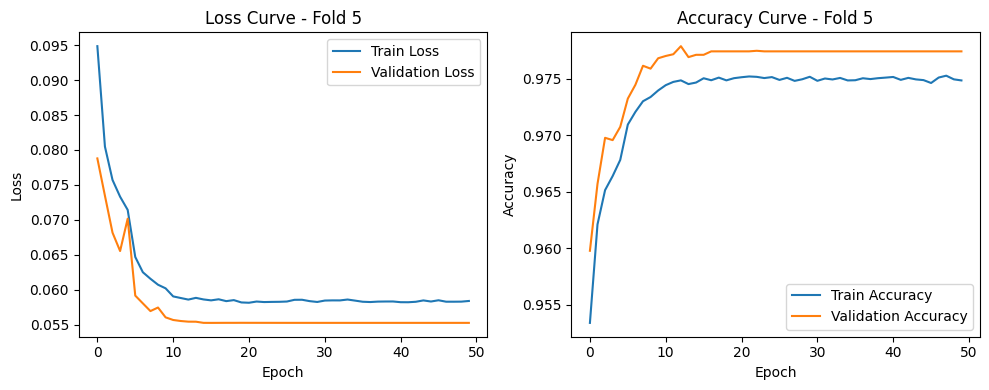

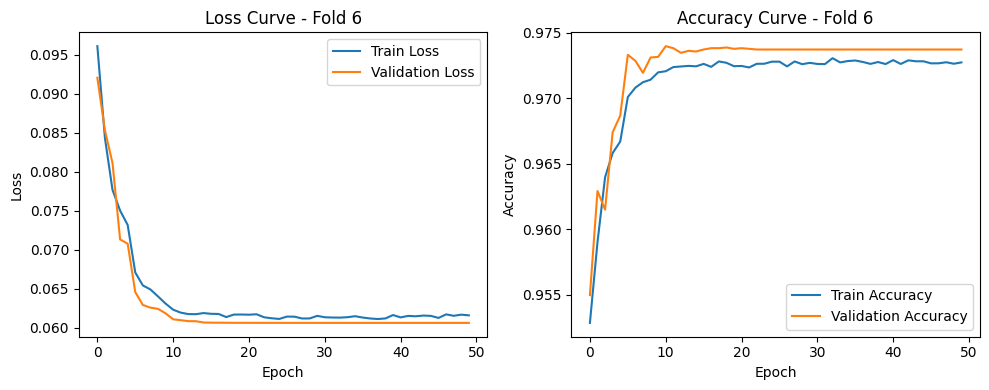

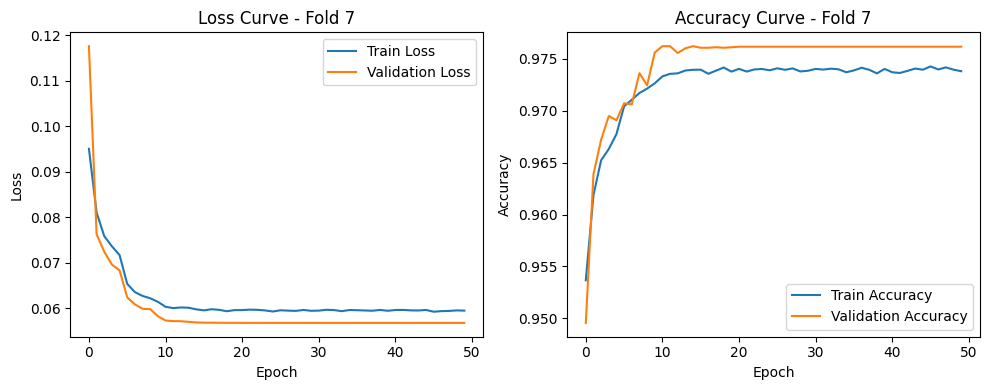

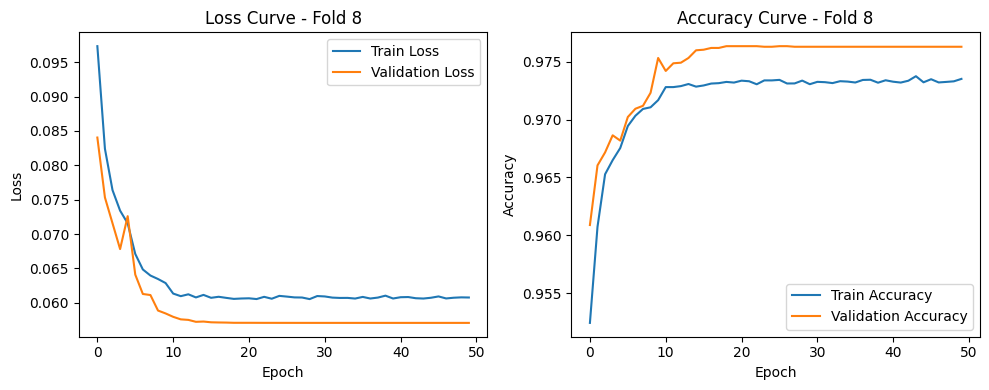

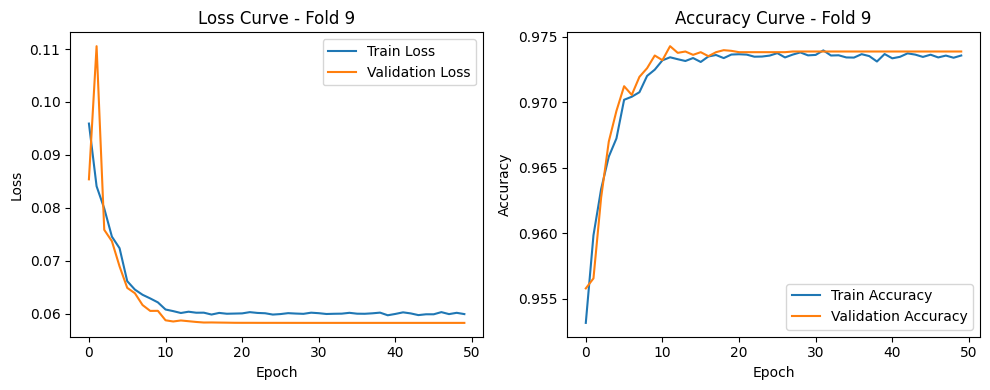

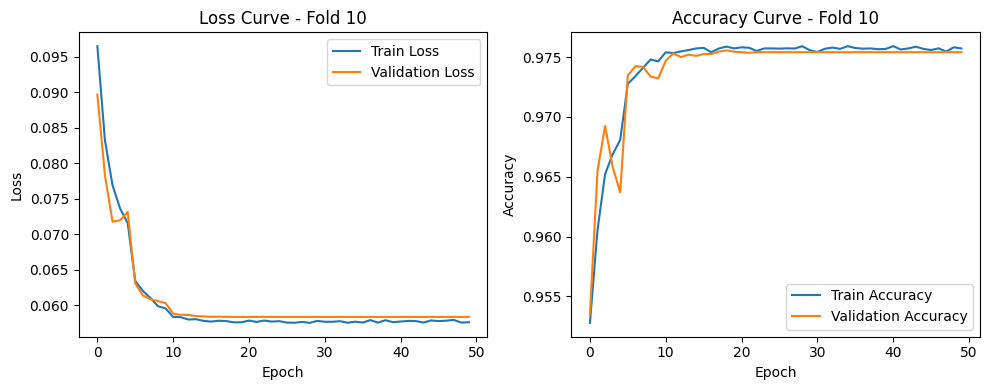

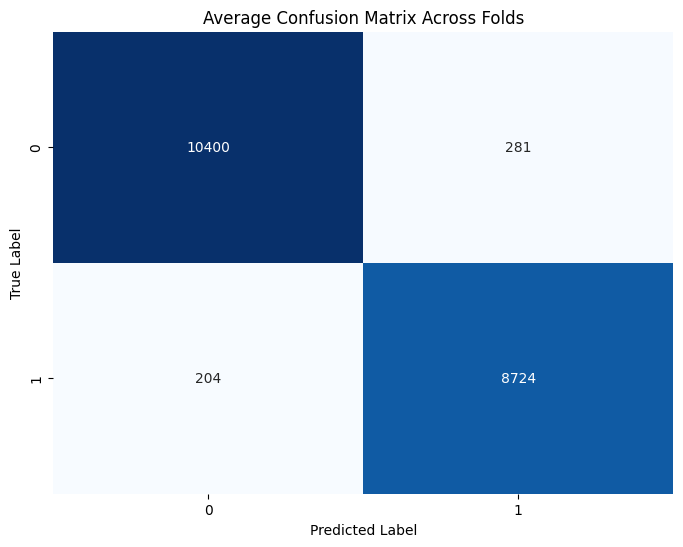

In [39]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preprocessing: Label Encoding dan Normalization
class_names = le1.classes_  # Save the original class names

# Normalize feature data
scaler = StandardScaler()
X_bin = scaler.fit_transform(combined_df.drop(columns=['type']).values)
y_bin = combined_df['type'].values

# 2. Define Transformer Decoder Model
class TransformerDecoderModel(nn.Module):
    def __init__(self, input_dim, num_classes, max_seq_len=1):
        super(TransformerDecoderModel, self).__init__()
        self.embedding = nn.Linear(input_dim, 64)  # Project input to 64-dimensional space
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_seq_len, 64))  # Positional encoding
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=64, nhead=2, batch_first=True)
        self.transformer_decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=2)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)  # Add sequence length dimension (batch_size, seq_len, d_model)
        x += self.positional_encoding[:, :x.size(1), :]  # Add positional encoding
        x = self.transformer_decoder(x, memory=x)  # Memory = input itself for self-attention
        x = x.mean(dim=1)  # Average pooling across sequence length
        return self.fc(x)

# 3. KFold Cross-Validation
kf = KFold(n_splits=10, shuffle=True, random_state=50)
all_accuracy, all_f1_scores, all_precision_scores, all_recall_scores = [], [], [], []
conf_matrix_list = []
all_train_losses, all_val_losses, all_train_accuracies, all_val_accuracies = [], [], [], []

for fold, (train_index, val_index) in enumerate(kf.split(X_bin)):
    print(f'Fold {fold + 1}')

    # Split data
    X_train, X_val = X_bin[train_index], X_bin[val_index]
    y_train, y_val = y_bin[train_index], y_bin[val_index]

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.LongTensor(y_val)

    # Create DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

    # Initialize the model
    model = TransformerDecoderModel(input_dim=X_train.shape[1], num_classes=len(class_names))
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # Early stopping setup
    best_accuracy = 0
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    num_epochs = 50

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        scheduler.step()

        # Calculate average training loss and accuracy for this epoch
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validate the model
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            y_pred_probs = model(X_val_tensor)
            val_loss = criterion(y_pred_probs, y_val_tensor).item()
            val_running_loss += val_loss
            _, y_pred = torch.max(y_pred_probs, 1)

        avg_val_loss = val_running_loss
        val_losses.append(avg_val_loss)
        val_accuracy = accuracy_score(y_val, y_pred.numpy())
        val_accuracies.append(val_accuracy)

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'model_fold_{fold + 1}.pt')

        print(f"Epoch {epoch + 1}/{num_epochs} - "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accuracies.append(train_accuracies)
    all_val_accuracies.append(val_accuracies)

    conf_matrix = confusion_matrix(y_val, y_pred.numpy())
    conf_matrix_list.append(conf_matrix)
    all_accuracy.append(val_accuracy)

    f1 = f1_score(y_val, y_pred.numpy(), average='weighted')
    precision = precision_score(y_val, y_pred.numpy(), average='weighted')
    recall = recall_score(y_val, y_pred.numpy(), average='weighted')

    all_f1_scores.append(f1)
    all_precision_scores.append(precision)
    all_recall_scores.append(recall)

    # Plot confusion matrix for each fold
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - Fold {fold + 1}')
    plt.show()

    # Print the metrics for the current fold
    print(f"Fold {fold + 1} - Accuracy: {val_accuracy * 100:.2f}%")
    print(f"Fold {fold + 1} - F1 Score: {f1:.4f}")
    print(f"Fold {fold + 1} - Precision: {precision:.4f}")
    print(f"Fold {fold + 1} - Recall: {recall:.4f}")


# 4. Average Metrics Across All Folds
print(f'Average Accuracy: {np.mean(all_accuracy) * 100:.2f}%')
print(f'Average F1 Score: {np.mean(all_f1_scores):.4f}')
print(f'Average Precision: {np.mean(all_precision_scores):.4f}')
print(f'Average Recall: {np.mean(all_recall_scores):.4f}')

# Plot loss and accuracy for each fold
for fold in range(len(all_train_losses)):
    plt.figure(figsize=(10, 4))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(all_train_losses[fold], label='Train Loss')
    plt.plot(all_val_losses[fold], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve - Fold {fold + 1}')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(all_train_accuracies[fold], label='Train Accuracy')
    plt.plot(all_val_accuracies[fold], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Curve - Fold {fold + 1}')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 5. Plot the Average Confusion Matrix
average_conf_matrix = np.mean(conf_matrix_list, axis=0)

plt.figure(figsize=(8, 6))
sns.heatmap(average_conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Average Confusion Matrix Across Folds')
plt.show()


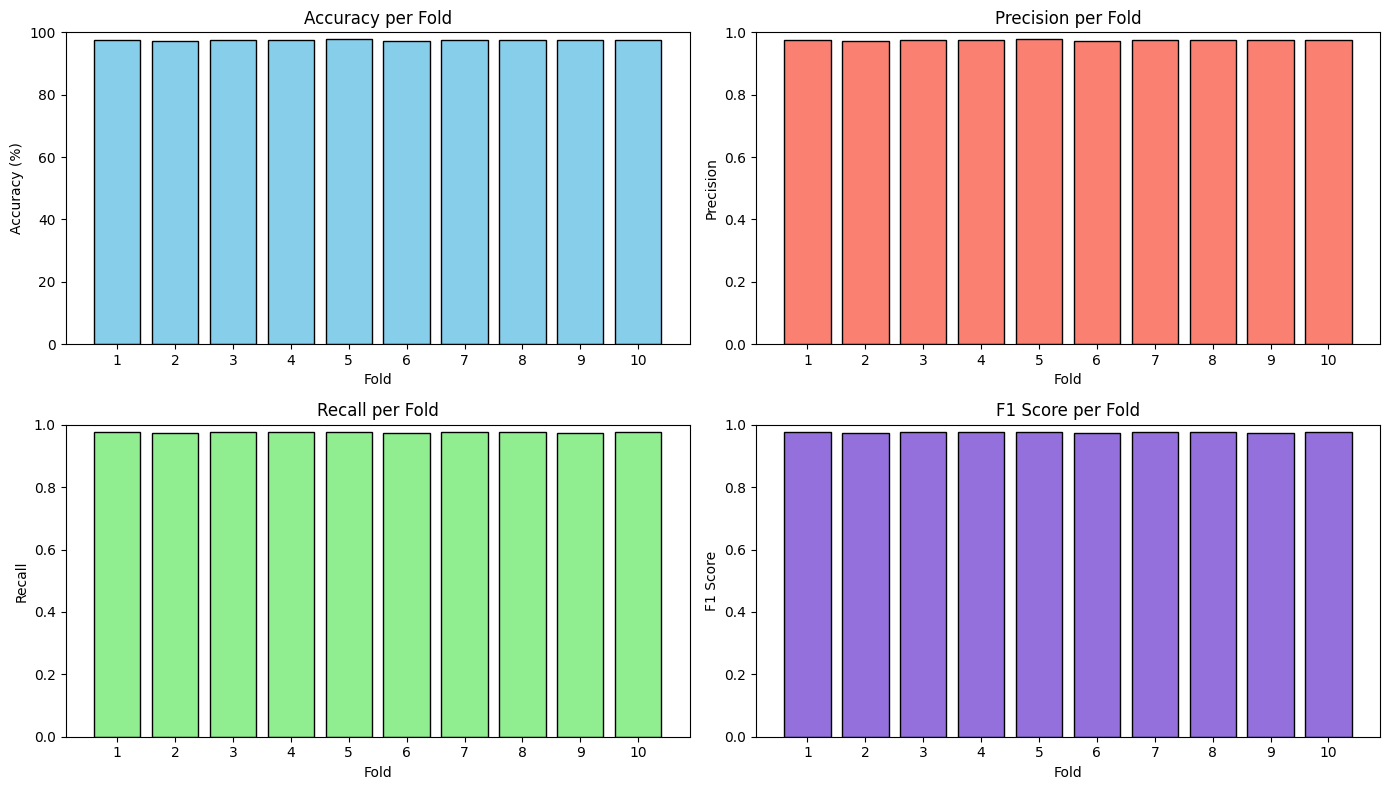

In [40]:
# 6. Plot Metrics per Fold
folds = list(range(1, len(all_accuracy) + 1))

plt.figure(figsize=(14, 8))

# Plot Accuracy
plt.subplot(2, 2, 1)
plt.bar(folds, [acc * 100 for acc in all_accuracy], color='skyblue', edgecolor='black')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Fold')
plt.xticks(folds)
plt.ylim(0, 100)

# Plot Precision
plt.subplot(2, 2, 2)
plt.bar(folds, all_precision_scores, color='salmon', edgecolor='black')
plt.xlabel('Fold')
plt.ylabel('Precision')
plt.title('Precision per Fold')
plt.xticks(folds)
plt.ylim(0, 1)

# Plot Recall
plt.subplot(2, 2, 3)
plt.bar(folds, all_recall_scores, color='lightgreen', edgecolor='black')
plt.xlabel('Fold')
plt.ylabel('Recall')
plt.title('Recall per Fold')
plt.xticks(folds)
plt.ylim(0, 1)

# Plot F1 Score
plt.subplot(2, 2, 4)
plt.bar(folds, all_f1_scores, color='mediumpurple', edgecolor='black')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.title('F1 Score per Fold')
plt.xticks(folds)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()


# Test

In [47]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Asumsi: X_train dan y_train adalah dataset pelatihan yang sudah disiapkan sebelumnya
# Asumsi: X_test dan y_test adalah dataset uji yang sudah disiapkan sebelumnya

# 1. Inisialisasi dan Fit Scaler pada X_train
scaler = StandardScaler()

# Fit scaler ke data pelatihan
X_train_scaled = scaler.fit_transform(X_train)

# 2. Transformasi X_test menggunakan scaler yang sama
X_test_scaled = scaler.transform(X_test)  # Menggunakan scaler yang sama untuk X_test

# 3. Konversi data menjadi tensor PyTorch
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test.values.flatten())  # Pastikan label 1D

# 4. Membuat DataLoader untuk dataset uji
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 5. Memuat model yang terbaik dari fold dengan akurasi tertinggi
best_fold = np.argmax(all_accuracy)  # Mendapatkan fold dengan akurasi tertinggi
model_path = f'model_fold_{best_fold + 1}.pt'
model.load_state_dict(torch.load(model_path))

# 6. Pindahkan model ke mode evaluasi
model.eval()

# 7. Loop untuk pengujian
test_running_loss = 0.0
correct_test = 0
total_test = 0
y_test_pred = []

# Menonaktifkan gradient computation untuk efisiensi
with torch.no_grad():
    for inputs, labels in test_loader:
        print(f"Input shape: {inputs.shape}, Labels shape: {labels.shape}")  # Mengecek bentuk tensor
        
        # Forward pass
        outputs = model(inputs)
        
        # Menghitung loss
        loss = criterion(outputs, labels)
        test_running_loss += loss.item()
        
        # Menghitung akurasi pengujian
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)
        
        # Mengumpulkan prediksi
        y_test_pred.extend(predicted.numpy())

# 8. Menghitung rata-rata loss dan akurasi pengujian
avg_test_loss = test_running_loss / len(test_loader)
test_accuracy = correct_test / total_test

# 9. Mencetak hasil pengujian
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {avg_test_loss:.4f}')



C:\Users\LENOVO\AppData\Local\Temp\ipykernel_35372\3593838624.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Input shape: torch.Size([16, 517]), Labels shape: torch.Size([16])
Input shape: torch.Size([16, 517]), Labels shape: torch.Size([16])
Input shape: torch.Size([16, 517]), Labels shape: torch.Size([16])
Input shape: torch.Size([16, 517]), Labels shape: torch.Size([16])
Input shape: torch.Size([16, 517]), Labels shape: torch.Size([16])
Input shape: torch.Size([16, 517]), Labels shape: torch.Size([16])
Input shape: torch.Size([16, 517]), Labels shape: torch.Size([16])
Input shape: torch.Size([16, 517]), Labels shape: torch.Size([16])
Input shape: torch.Size([16, 517]), Labels shape: torch.Size([16])
Input shape: torch.Size([16, 517]), Labels shape: torch.Size([16])
Input shape: torch.Size([16, 517]), Labels shape: torch.Size([16])
Input shape: torch.Size([16, 517]), Labels shape: torch.Size([16])
Input shape: torch.Size([16, 517]), Labels shape: torch.Size([16])
Input shape: torch.Size([16, 517]), Labels shape: torch.Size([16])
Input shape: torch.Size([16, 517]), Labels shape: torch.Size([

In [ ]:
# Pastikan y_test dalam format array 1D
y_test_labels = y_test.values.flatten()  # Jika y_test adalah DataFrame

# Pastikan class_names terdefinisi dengan benar
class_names = ['Class 0', 'Class 1']  # Sesuaikan dengan jumlah kelas yang ada

# 10. Laporan klasifikasi untuk dataset uji
print('Test Classification Report:')
print(classification_report(y_test_labels, y_test_pred, target_names=class_names))

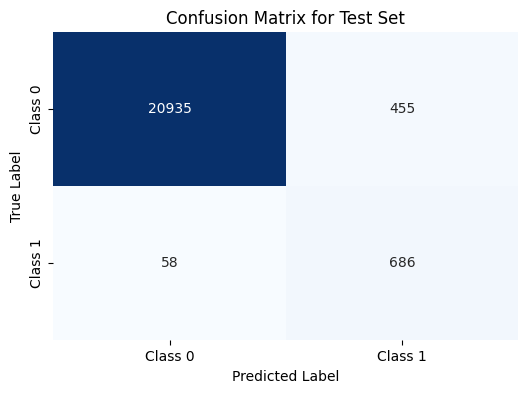

In [48]:
# 11. Matriks kebingunguan untuk dataset uji
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_test, annot=True, fmt='.0f', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Test Set')
plt.show()


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_35372\659560277.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Accuracy: 97.66%
Test Loss: 0.0753
Test Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.98      0.99     21390
     Class 1       0.60      0.92      0.73       744

    accuracy                           0.98     22134
   macro avg       0.80      0.95      0.86     22134
weighted avg       0.98      0.98      0.98     22134



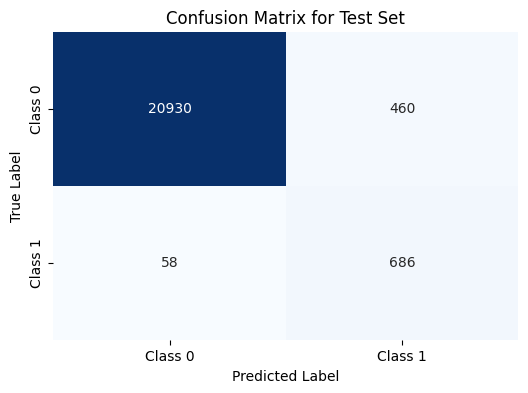

In [50]:
# 5. Testing
# Assume X_test and y_test are dataset testing yang sudah dipersiapkan sebelumnya
# X_test adalah data fitur dan y_test adalah label yang sesuai

# Normalize test data using the same scaler
X_test = scaler.transform(X_test)

# Convert to PyTorch tensor
X_test_tensor = torch.FloatTensor(X_test)
# Ensure y_test is 1D
y_test_tensor = torch.LongTensor(y_test.values.ravel())  # Add .ravel() to ensure 1D

# Create DataLoader for the test dataset
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize the model (load the best model from the fold with highest accuracy)
best_fold = np.argmax(all_accuracy)  # Get the fold with the highest accuracy
model_path = f'model_fold_{best_fold + 1}.pt'
model.load_state_dict(torch.load(model_path))

# Put model in evaluation mode
model.eval()

# Testing loop
test_running_loss = 0.0
correct_test = 0
total_test = 0
y_test_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        # Ensure labels are the correct shape
        labels = labels.view(-1)  # Reshape to 1D if needed
        loss = criterion(outputs, labels)
        test_running_loss += loss.item()
        
        # Calculate test accuracy
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)
        
        y_test_pred.extend(predicted.cpu().numpy())

# Calculate average test loss and accuracy
avg_test_loss = test_running_loss / len(test_loader)
test_accuracy = correct_test / total_test

# Print test results
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {avg_test_loss:.4f}')

# Classification report on test set
print('Test Classification Report:')
print(classification_report(y_test, y_test_pred, target_names=class_names))

# Confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_test, annot=True, fmt='.0f', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Test Set')
plt.show()